In [4]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import sys
sys.path.append("/Users/kaylahuang/Desktop/GitHub/conflicts/components/")

from views_cleaner import VIEWSCleaner

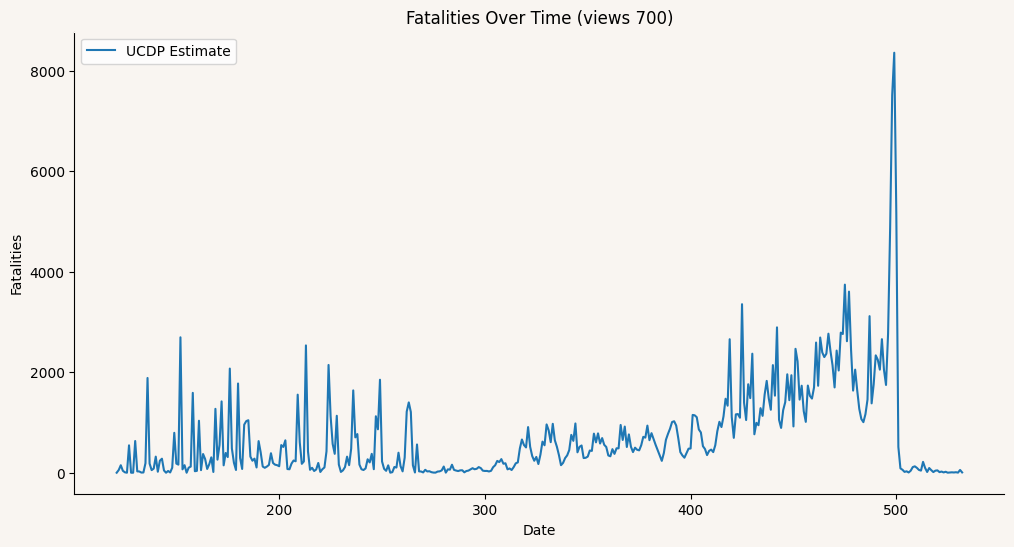

In [5]:
filename = '../data/views23/features/cm/cm_features.parquet'
gw_id = 700 # this is sri lanka
cleaner = VIEWSCleaner(filename, gw_id)
X = cleaner.features # already aggregated by month
cleaner.plot()


In [6]:
def predict_date(input_month):
    pre_date = X[X['month_id'] <= input_month]
    X_train = pre_date.drop(columns=["ged_sb"])
    y_train = pre_date["ged_sb"]
    
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    
    # prediction
    row = X[X['month_id'] == input_month]
    prediction = model.predict(row.drop(columns=["ged_sb"]))
    return prediction[0], row["ged_sb"].values[0], model.feature_importances_
    

In [20]:
month = 360

importances_list = [] 

for m in range(month, month+10):
    p, true, feature_imp = predict_date(m)
    print("prediction: ", p)
    print("true: ", true)
    importances_list.append(feature_imp)



prediction:  406.41
true:  344
prediction:  364.85
true:  327
prediction:  444.77
true:  469
prediction:  396.91
true:  375
prediction:  459.91
true:  486
prediction:  480.23
true:  485
prediction:  743.93
true:  950
prediction:  680.69
true:  652
prediction:  848.86
true:  918
prediction:  636.84
true:  512


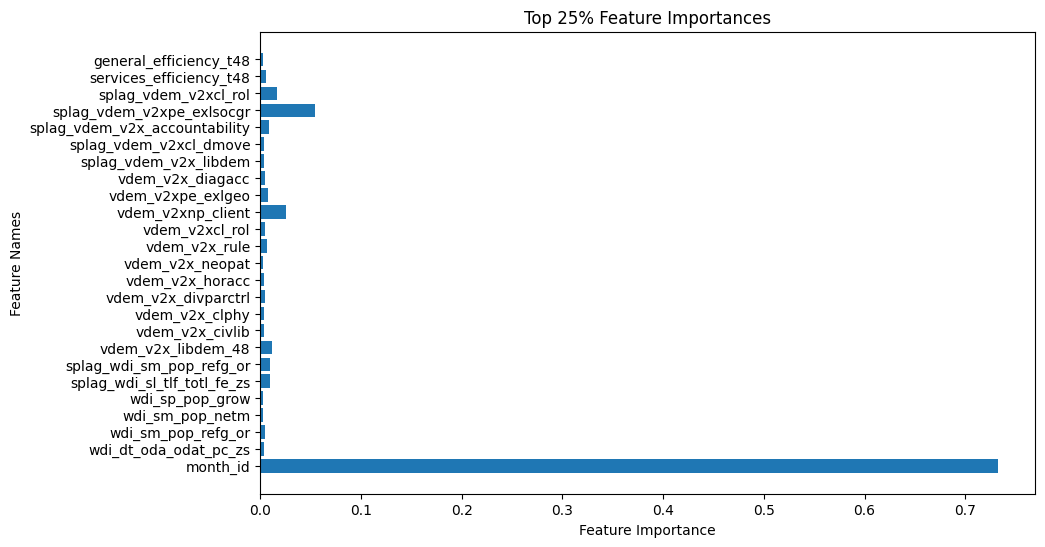

In [44]:
# plotting feature importance for one model 
importances = feature_imp
feature_names = X.drop(columns=["ged_sb"]).columns

# Get the threshold for the top 25% important features
threshold = np.percentile(importances, 75)
filtered_importances = importances[importances >= threshold]
filtered_feature_names = feature_names[importances >= threshold]

plt.figure(figsize=(10, 6))
plt.barh(filtered_feature_names, filtered_importances)
plt.xlabel('Feature Importance')
plt.ylabel('Feature Names')
plt.title('Top 25% Feature Importances')
plt.show()

In [43]:
feature_names = X.drop(columns=["ged_sb"]).columns

# Create a DataFrame to store feature importances from all models
importance_df = pd.DataFrame(importances_list, columns=feature_names)
print(importance_df.head(5))

# Calculate the mean importance for each feature across all models
mean_importances = importance_df.mean(axis=0)

# Get the top 5 features based on mean importance
top_features = mean_importances.nlargest(5).index

print(list(top_features))
# col_indices = [importance_df.index(col) for col in top_features]
# importance_df[col_indices]

# # Plot the importance of the top 5 features across all models
# plt.figure(figsize=(10, 6))
# for i, importances in enumerate(importances_list):
#     plt.barh(top_features, importances[top_features].values, alpha=0.5, label=f'Model {i+1}')

# # plt.xlabel('Feature Importance')
# # plt.ylabel('Feature Names')
# # plt.title('Top 5 Feature Importances Across Models')
# # plt.legend()
# # plt.show()


   month_id  country_id  gleditsch_ward  wdi_sp_pop_totl  wdi_ag_lnd_frst_k2  \
0  0.741008         0.0             0.0         0.000535                 0.0   
1  0.738596         0.0             0.0         0.000628                 0.0   
2  0.739446         0.0             0.0         0.000230                 0.0   
3  0.740804         0.0             0.0         0.000113                 0.0   
4  0.738592         0.0             0.0         0.000048                 0.0   

   wdi_dt_oda_odat_pc_zs  wdi_ms_mil_xpnd_gd_zs  wdi_ms_mil_xpnd_zs  \
0               0.004358               0.000797            0.000660   
1               0.004220               0.000748            0.000697   
2               0.003242               0.000789            0.000120   
3               0.003995               0.000730            0.000167   
4               0.003388               0.000303            0.000183   

   wdi_nv_agr_totl_kd  wdi_nv_agr_totl_kn  ...  dam_cap_pcap_t48  \
0            0.000442   

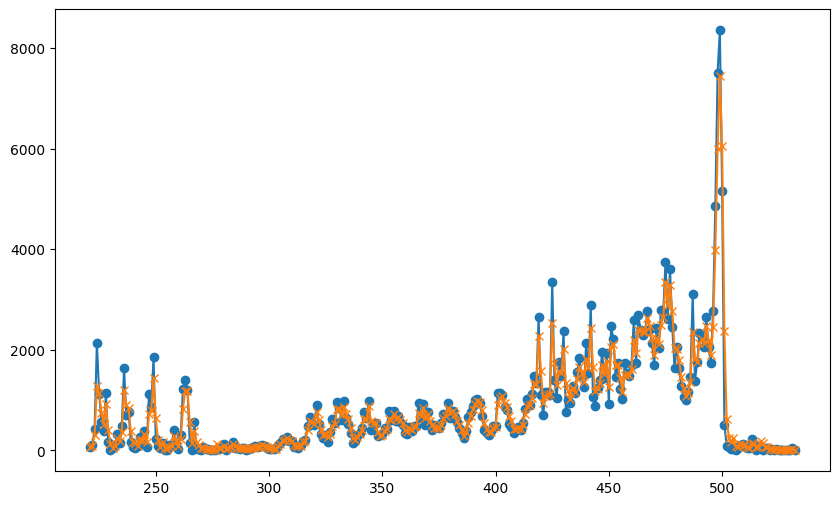

In [11]:
dates_to_predict = X['month_id'].values[100:]

ground_truth = []
predictions = []

for date in dates_to_predict:
    p, t, feature_imp = predict_date(date)
    ground_truth.append(t)
    predictions.append(p)

plt.figure(figsize=(10, 6))

plt.plot(dates_to_predict, ground_truth, label='Actual', marker='o')
plt.plot(dates_to_predict, predictions, label='Predicted', marker='x')


In [12]:
mse = mean_squared_error(ground_truth, predictions)
print(mse) # 7051.357089690721 for sri lanka 

54524.80105641026


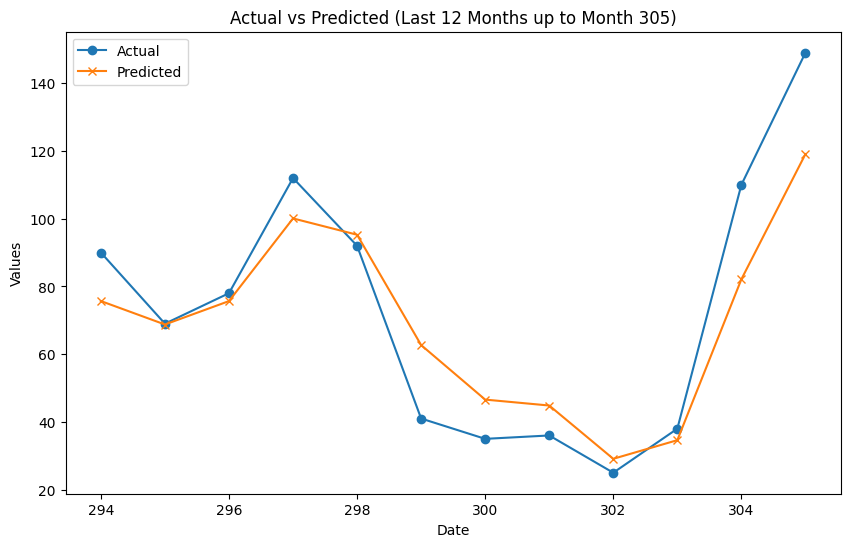

In [16]:
# Define the window size
window_size = 12

# function to plot the last 'window_size' data points from a given month
def plot_last_window_from_month(month, window_size):
    if month in dates_to_predict:
        month_index = list(dates_to_predict).index(month)
        
        # Ensure there are enough data points
        if month_index + 1 >= window_size:
            # Select the last 'window_size' data points up to the given month
            window_dates = dates_to_predict[month_index + 1 - window_size:month_index + 1]
            window_ground_truth = ground_truth[month_index + 1 - window_size:month_index + 1]
            window_predictions = predictions[month_index + 1 - window_size:month_index + 1]

            # Plot the smaller subset
            plt.figure(figsize=(10, 6))
            plt.plot(window_dates, window_ground_truth, label='Actual', marker='o')
            plt.plot(window_dates, window_predictions, label='Predicted', marker='x')
            plt.xlabel('Date')
            plt.ylabel('Values')
            plt.title(f'Actual vs Predicted (Last {window_size} Months up to Month {month})')
            plt.legend()
            plt.show()
        else:
            print(f"Not enough data points to create a window of {window_size} months up to month {month}.")
    else:
        print(f"Month {month} is not in the dates to predict.")

# Example usage
plot_last_window_from_month(305, window_size)
